## Binary Pet Classifier - Dog or Cat

This project classifies images of my pet dog Winnie and my sister's kitten Fern. Uses a baseline CNN to find ideal learning rate, then implement image augmentation and transfer learning to improve model accuracy.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 # Let's visualise our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
#  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return

In [ ]:
import os

# Walk through pet_classifier directory and list number of files

for dirpath, dirnames, filenames in os.walk("/content/gdrive/MyDrive/tensorflow_course/pet_classifier"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier'
There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train'
There are 0 directories and 78 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/fern'
There are 0 directories and 117 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/winnie'
There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test'
There are 0 directories and 36 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/winnie'
There are 0 directories and 28 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/fern'


Image shape: (1042, 831, 3)


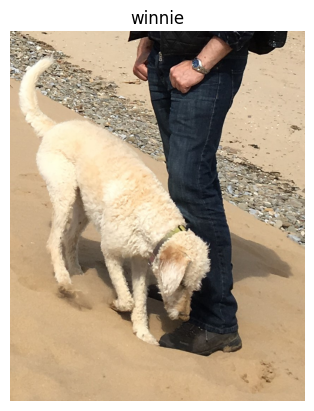

In [ ]:
view_random_image("/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/", "winnie")

In [ ]:
# Get the classnames programmatically

import pathlib
import numpy as np
data_dir = pathlib.Path("/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['fern' 'winnie']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed

tf.random.set_seed(42)

# Preprocess data (get all pixel values between 0 and 1, also called scaling/normalisation)

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Set up paths to our data directories
train_dir = "/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/"
test_dir = "/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size =32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed = 42)



Found 195 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [ ]:
# Build a baseline CNN model (same as the Tiny VGG on the CNN explainer website)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Compile our CNN

model_1.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Create a learning rate callback:
# the lr_scheduler function below increases the lr by 10^epoch/20 every epoch, starting at lr = 1e-4.

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
# fit the model

history_1 = model_1.fit(train_data,
                        epochs = 50,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data),
                        callbacks = [lr_scheduler]
                        )

Epoch 1/50
7/7 [==============================] - 18s 3s/step - loss: 0.6923 - accuracy: 0.5538 - val_loss: 0.7406 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 0.6730 - accuracy: 0.6000 - val_loss: 0.7336 - val_accuracy: 0.5625 - lr: 1.1220e-04
Epoch 3/50
7/7 [==============================] - 23s 4s/step - loss: 0.6555 - accuracy: 0.6000 - val_loss: 0.7112 - val_accuracy: 0.5625 - lr: 1.2589e-04
Epoch 4/50
7/7 [==============================] - 14s 2s/step - loss: 0.6433 - accuracy: 0.6000 - val_loss: 0.6997 - val_accuracy: 0.5625 - lr: 1.4125e-04
Epoch 5/50
7/7 [==============================] - 14s 2s/step - loss: 0.6311 - accuracy: 0.6000 - val_loss: 0.6785 - val_accuracy: 0.5625 - lr: 1.5849e-04
Epoch 6/50
7/7 [==============================] - 15s 2s/step - loss: 0.6155 - accuracy: 0.6000 - val_loss: 0.6825 - val_accuracy: 0.5625 - lr: 1.7783e-04
Epoch 7/50
7/7 [==============================] - 15s 3s/step - loss: 

<Axes: xlabel='epochs'>

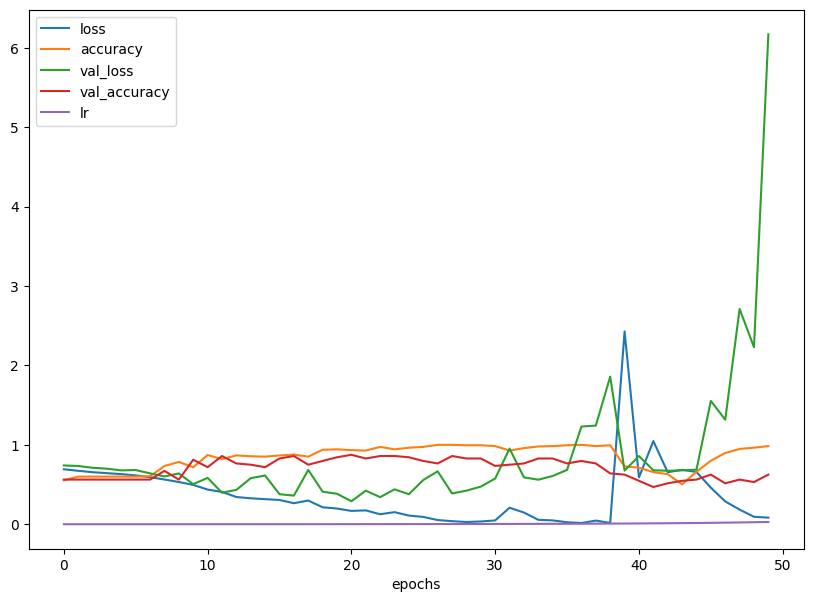

In [ ]:
# Ideal learning rate - plot
import pandas as pd
# Check out the history
pd.DataFrame(history_1.history).plot(figsize = (10, 7), xlabel = 'epochs')


Text(0.5, 1.0, 'Learning rate vs Loss')

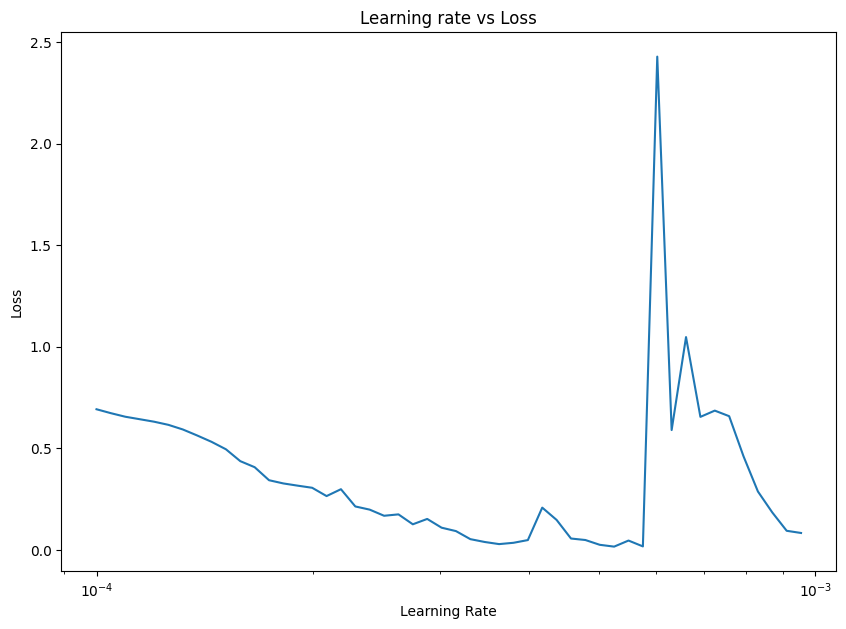

In [ ]:
# Plot the learning rate values during training vs the loss

lrs = 1e-4 * (10 ** (tf.range(50)/50))

plt.figure(figsize = (10, 7))
plt.semilogx(lrs, history_1.history["loss"], base = 10)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs Loss")

In [ ]:
# find array position of min loss
tf.argmin(history_1.history['loss'])

# take position before for learning rates array to get the ideal lr
lrs[35]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0005011872336272723>

In [ ]:
 # 20 epochs using default learning rate 0.001

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Compile our CNN

model_2.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# fit the model

history_2 = model_2.fit(train_data,
                        epochs = 20,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data)
                        )

Epoch 1/20
7/7 [==============================] - 18s 3s/step - loss: 1.0192 - accuracy: 0.5590 - val_loss: 0.7002 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 15s 2s/step - loss: 0.7211 - accuracy: 0.4564 - val_loss: 0.6820 - val_accuracy: 0.5781
Epoch 3/20
7/7 [==============================] - 23s 3s/step - loss: 0.6397 - accuracy: 0.6000 - val_loss: 0.7156 - val_accuracy: 0.5625
Epoch 4/20
7/7 [==============================] - 24s 3s/step - loss: 0.6369 - accuracy: 0.6000 - val_loss: 0.7064 - val_accuracy: 0.5625
Epoch 5/20
7/7 [==============================] - 18s 3s/step - loss: 0.6104 - accuracy: 0.6359 - val_loss: 0.6594 - val_accuracy: 0.6250
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 0.5628 - accuracy: 0.7538 - val_loss: 0.6574 - val_accuracy: 0.6406
Epoch 7/20
7/7 [==============================] - 22s 3s/step - loss: 0.5236 - accuracy: 0.7692 - val_loss: 0.5547 - val_accuracy: 0.7656
Epoch 8/20
7/7 [==================

In [ ]:
model_2.evaluate(valid_data)

2/2 [==============================] - 6s 2s/step - loss: 0.3709 - accuracy: 0.8125


[0.37087997794151306, 0.8125]

In [ ]:
 # 20 epochs using ideal learning rate 0.000501187

model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Compile our CNN

model_3.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000501187),
                metrics = ["accuracy"])

# fit the model

history_3 = model_3.fit(train_data,
                        epochs = 20,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data)
                        )

Epoch 1/20
7/7 [==============================] - 19s 2s/step - loss: 0.6871 - accuracy: 0.5949 - val_loss: 0.6912 - val_accuracy: 0.4844
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 0.6737 - accuracy: 0.5590 - val_loss: 0.6942 - val_accuracy: 0.5625
Epoch 3/20
7/7 [==============================] - 19s 3s/step - loss: 0.6275 - accuracy: 0.6051 - val_loss: 0.7010 - val_accuracy: 0.5625
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 0.6055 - accuracy: 0.6615 - val_loss: 0.6334 - val_accuracy: 0.6406
Epoch 5/20
7/7 [==============================] - 14s 2s/step - loss: 0.5568 - accuracy: 0.6769 - val_loss: 0.6745 - val_accuracy: 0.5625
Epoch 6/20
7/7 [==============================] - 14s 2s/step - loss: 0.5172 - accuracy: 0.7026 - val_loss: 0.5894 - val_accuracy: 0.6719
Epoch 7/20
7/7 [==============================] - 14s 2s/step - loss: 0.4516 - accuracy: 0.8513 - val_loss: 0.5112 - val_accuracy: 0.7500
Epoch 8/20
7/7 [==================

In [ ]:
model_3.evaluate(valid_data)

2/2 [==============================] - 6s 4s/step - loss: 0.4539 - accuracy: 0.8125


[0.45389077067375183, 0.8125]

In [ ]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """

  Returns separate loss curves for training and validation metrics.

  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

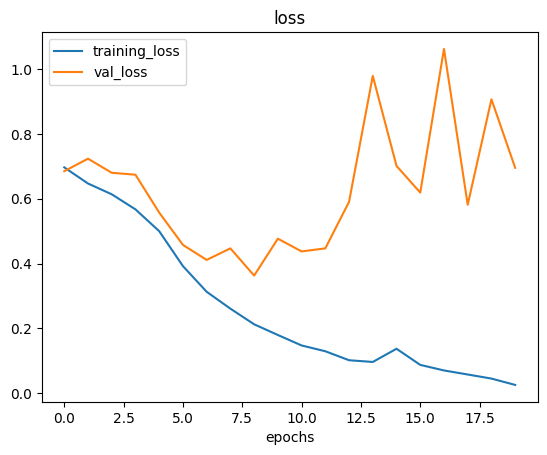

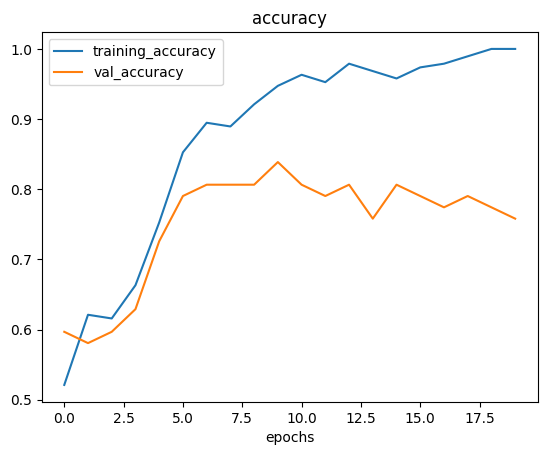

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 29160)           

In [ ]:
# Create ImageDataGenerator training instance with data augmentation

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             rotation_range = 0.2, # how much do you want to rotate an image?
                                             shear_range = 0.2, # how much do you want to shear an image?
                                             zoom_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.3,
                                             horizontal_flip = True)



In [ ]:
# Shuffle training data

print("Shuffled training data:")
train_data_shuffled = train_datagen.flow_from_directory(train_dir,
                                                        target_size = (224,224),
                                                        batch_size = 32,
                                                        class_mode = "binary",
                                                        shuffle = True) # shuffle data from training directory

Shuffled training data:
Found 195 images belonging to 2 classes.


In [ ]:
# Add data augmentation to model to produce more variety, used shuffled train data

model_2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Compile our CNN

model_2.compile( loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# fit the model

history_2 = model_2.fit(train_data_shuffled,
                        epochs = 30,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data)
                        )

Epoch 1/30
7/7 [==============================] - 67s 9s/step - loss: 0.6879 - accuracy: 0.5282 - val_loss: 0.6980 - val_accuracy: 0.5625
Epoch 2/30
7/7 [==============================] - 21s 3s/step - loss: 0.6599 - accuracy: 0.6000 - val_loss: 0.7187 - val_accuracy: 0.5625
Epoch 3/30
7/7 [==============================] - 15s 2s/step - loss: 0.6438 - accuracy: 0.6000 - val_loss: 0.7133 - val_accuracy: 0.5625
Epoch 4/30
7/7 [==============================] - 15s 2s/step - loss: 0.6484 - accuracy: 0.6000 - val_loss: 0.6996 - val_accuracy: 0.5625
Epoch 5/30
7/7 [==============================] - 15s 2s/step - loss: 0.6313 - accuracy: 0.6154 - val_loss: 0.5400 - val_accuracy: 0.8281
Epoch 6/30
7/7 [==============================] - 15s 2s/step - loss: 0.5723 - accuracy: 0.7590 - val_loss: 0.5532 - val_accuracy: 0.6094
Epoch 7/30
7/7 [==============================] - 15s 2s/step - loss: 0.5102 - accuracy: 0.7179 - val_loss: 0.5029 - val_accuracy: 0.7656
Epoch 8/30
7/7 [==================

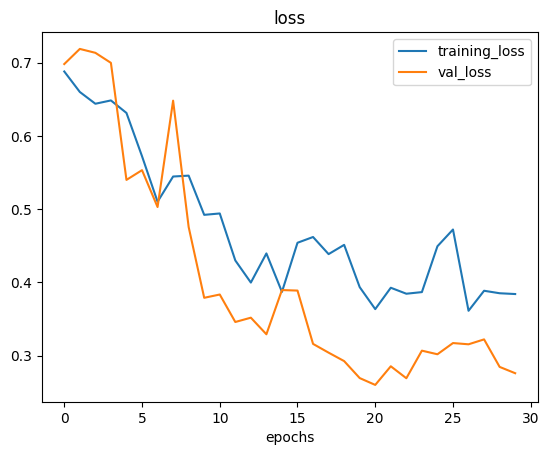

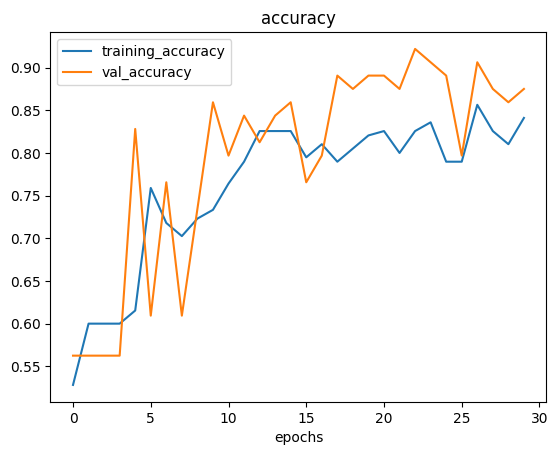

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, None)  0         
                                                                 
 random_rotation (RandomRota  (None, None, None, None)  0        
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, None, None, None)  0        
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, None, None, 10)    280       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 10)   0

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model.
def load_and_prep_image(filename, img_shape = 224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, channels).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size =  [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


In [ ]:
def pred_and_plot(model, filename, class_names = class_names):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis = 0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


In [ ]:
model_2.evaluate(valid_data)

2/2 [==============================] - 5s 2s/step - loss: 0.2762 - accuracy: 0.8750


[0.27620381116867065, 0.875]

1/1 [==============================] - 0s 28ms/step


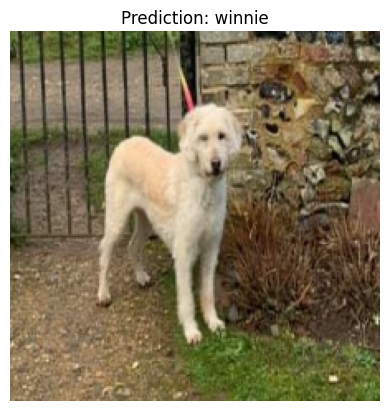

In [ ]:
pred_and_plot(model_2, "testw.jpg", class_names)

## Image classification of Fern and Winnie using transfer learning

In [ ]:
 # Let's visualise our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
#  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return

In [ ]:
import os

# Walk through pet_classifier directory and list number of files

for dirpath, dirnames, filenames in os.walk("/content/gdrive/MyDrive/tensorflow_course/pet_classifier"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier'
There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train'
There are 0 directories and 78 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/fern'
There are 0 directories and 117 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/winnie'
There are 2 directories and 0 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test'
There are 0 directories and 36 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/winnie'
There are 0 directories and 28 images in '/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/fern'


Image shape: (1042, 831, 3)


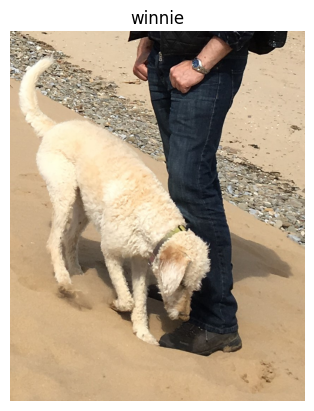

In [ ]:
view_random_image("/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/", "winnie")

In [ ]:
# Get the classnames programmatically

import pathlib
import numpy as np
data_dir = pathlib.Path("/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['fern' 'winnie']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed

tf.random.set_seed(42)

# Preprocess data (get all pixel values between 0 and 1, also called scaling/normalisation)

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Set up paths to our data directories
train_dir = "/content/gdrive/MyDrive/tensorflow_course/pet_classifier/train/"
test_dir = "/content/gdrive/MyDrive/tensorflow_course/pet_classifier/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size =32,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               seed = 42)



Found 195 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [ ]:
# Let's make a create_model() functio to create a model from a URL
def create_binary_model(model_url, num_classes = 2):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SHAPE + (3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(1, activation = "sigmoid", name = "output_layer")
  ])

  return model

In [ ]:
pet_model = create_binary_model(resnet_url, num_classes = train_data.num_classes)

In [ ]:
pet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
pet_model.compile(loss = "binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

In [ ]:
pet_history = pet_model.fit(train_data,
                            epochs = 5,
                            steps_per_epoch = len(train_data),
                            validation_data = valid_data,
                            validation_steps = len(valid_data),
                            callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                          experiment_name = "pet_resnet")])

Saving TensorBoard log files to: tensorflow_hub/pet_resnet/20230607-120615
Epoch 1/5
7/7 [==============================] - 63s 9s/step - loss: 0.4574 - accuracy: 0.8103 - val_loss: 0.3636 - val_accuracy: 0.8594
Epoch 2/5
7/7 [==============================] - 17s 3s/step - loss: 0.1733 - accuracy: 0.9641 - val_loss: 0.1844 - val_accuracy: 0.9219
Epoch 3/5
7/7 [==============================] - 18s 3s/step - loss: 0.0878 - accuracy: 0.9897 - val_loss: 0.1305 - val_accuracy: 0.9375
Epoch 4/5
7/7 [==============================] - 15s 2s/step - loss: 0.0555 - accuracy: 0.9949 - val_loss: 0.0986 - val_accuracy: 0.9688
Epoch 5/5
7/7 [==============================] - 15s 2s/step - loss: 0.0380 - accuracy: 0.9949 - val_loss: 0.0813 - val_accuracy: 0.9531


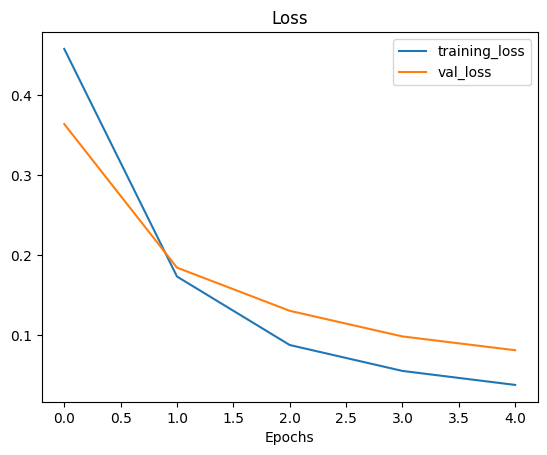

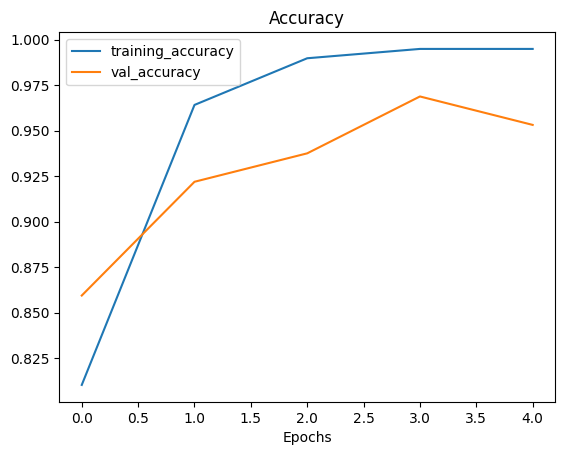

In [ ]:
plot_loss_curves(pet_history)